# **使用图像数据集训练一个目标检测模型  (TensorFlow 2.x)**

**[文章地址]()**

# **我们将介绍使用SSD模型训练一个自定义目标检测模型**




## **ROADMAP**


* 收集图像数据集，进行标注，生产xml文件。
* 安装TensorFlow对象检测API。
* 准备TFRecord训练文件。
* 编辑模型流水线配置文件，下载预训练模型检查点。
* 训练、测试模型。




# **1) 安装依赖库**

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

import tensorflow as tf
print(tf.__version__)

2.18.0


# **2) 在google drive上创建*`Object_Detection`*, *`training`* and *`data`* 文件夹**
在google drive上创建一个***Object_Detection***文件夹。

在***Object_Detection***目录下创建***training***文件夹，***training***文件夹保存训练过程中的checkpoints。

在***Object_Detection***目录下创建***data***文件夹。

# **3) 收集图像数据集，标注生成PASCAL_VOC XML文件**
免费图像标注工具https://github.com/HumanSignal/labelImg

图片标注原理可以参考 [文章](https://techzizou.com/dataset-labeling-annotation-tutorial-for-beginners/) 。

# **4) 上传*`generate_tfrecord.py`*到*`Object_Detection`*目录下**



下载 [generate_tfrecord.py](https://github.com/techzizou/Train-Object-Detection-Model-TF-2.x)

#**5) 挂载drive目录，做文件符号链接**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# 创建符号链接
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/Object_Detection

Mounted at /content/gdrive
annotations.zip  data  generate_tfrecord.py  images.zip  training


# **6) 下载tensorflow模型，安装tensflow对象检测API**






In [ ]:
# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

# **7) 切换到/mydrive/Object_Detection/data/目录，解压*images.zip* 和 *annotations.zip* 文件到*data* 目录**




In [ ]:
%cd /mydrive/Object_Detection/data/

# unzip the datasets and their contents so that they are now in /mydrive/Object_Detection/data/ folder
!unzip /mydrive/Object_Detection/images.zip -d .
!unzip /mydrive/Object_Detection/annotations.zip -d .

# **8) 创建 test_labels & train_labels**
当前工作目录 /mydrive/Object_Detection/data/

将标注文件分拆到test_labels(20%) 、 train_labels(80%)

In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 20% of the labels to the testing dir: `test_labels`
!ls annotations/* | sort -R | head -2 | xargs -I{} mv {} test_labels/


# Moves the rest of the labels to the training dir: `train_labels`
!ls annotations/* | xargs -I{} mv {} train_labels/

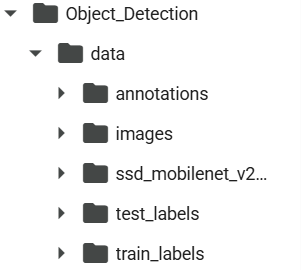

# **9) 创建 CSV 文件 和 "label_map.pbtxt" 文件**

当前工作目录 /mydrive/Object_Detection/data/

运行 xml_to_csv 脚本创建 ***test_labels.csv*** 、 ***train_labels.csv***、***label_map.pbtxt***

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')

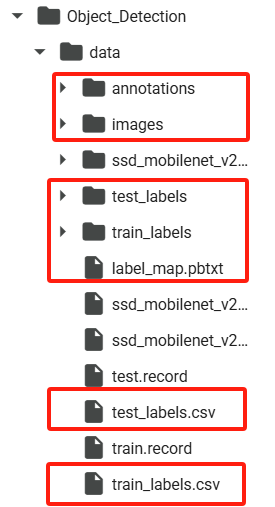

# **10) 创建 train.record & test.record**

当前工作路径 /mydrive/Object_Detection/data/

运行 *generate_tfrecord.py* 脚本生成 *train.record* 、 *test.record* 文件

In [ ]:
#Usage:
#!python generate_tfrecord.py output.csv output_pb.txt /path/to/images output.tfrecords

#For train.record
!python /mydrive/Object_Detection/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#For test.record
!python /mydrive/Object_Detection/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record


# **11) 下载预训模型**

当前工作目录 /mydrive/Object_Detection/data/

将 **ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz** 下载到 ***data*** 目录，解压.

tensorflow 2.x预训练模型 [访问地址](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).



In [ ]:
#Download the pre-trained model ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz into the data folder & unzip it.

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# **12) 配置模型训练文件, 配置好的文件存放到 *data* 目录**

当前工作目录 /mydrive/Object_Detection/data/

在colab编辑 ***/content/models/research/object_detection/configs/tf2*** ，拷贝到***/mydrive/Object_Detection/data*** 目录

**修改以下参数：**
*   ***num_classes***
*   ***test.record*** path, ***train.record*** path & ***labelmap*** path
*  ***fine_tune_checkpoint***
*  ***fine_tune_checkpoint_type***  **classification** or **detection**
*  ***batch_size***
*  ***num_steps***







In [ ]:
#copy the edited config file from the configs/tf2 directory to the data/ folder in your drive

!cp /content/models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config /mydrive/Object_Detection/data

# **13) 训练模型**






In [ ]:
%cd /content/models/research/object_detection

#step1
#!pip uninstall -y tensorflow
#!pip install tensorflow==2.13.0

#step2
!pip install numpy==1.26.4
!pip install protobuf==3.20

## **14) 使用model_main_tf2.py脚本进行模型训练**
为了获得最佳效果，当训练loss小于0.1或者loss没有显著变化的时候可以停止训练。立项的loss应该小于0.05。

In [ ]:
# Run the command below from the content/models/research/object_detection directory
"""
PIPELINE_CONFIG_PATH=path/to/pipeline.config
MODEL_DIR=path to training checkpoints directory
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

python model_main_tf2.py -- \
  --model_dir=$MODEL_DIR --num_train_steps=$NUM_TRAIN_STEPS \
  --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
  --pipeline_config_path=$PIPELINE_CONFIG_PATH \
  --alsologtostderr
"""
os.environ["TF_USE_LEGACY_KERAS"]="1"
!python model_main_tf2.py --pipeline_config_path=/content/gdrive/MyDrive/Object_Detection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/content/gdrive/MyDrive/Object_Detection/training --alsologtostderr

# **15) 测试训练模型**

## 导出推理模型

当前工作目录 /content/models/research/object_detection

In [ ]:
!python /content/models/research/object_detection/exporter_main_v2.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/gdrive/MyDrive/Object_Detection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config \
    --output_directory='/content/gdrive/MyDrive/Object_Detection/training/export' \
    --trained_checkpoint_dir='/content/gdrive/MyDrive/Object_Detection/training/'

In [ ]:
!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path=/content/gdrive/MyDrive/Object_Detection/data/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config \
    --output_directory='/content/gdrive/MyDrive/Object_Detection/training/export_tpu' \
    --trained_checkpoint_dir='/content/gdrive/MyDrive/Object_Detection/training/'

## 模型测试

当前工作目录 /content/models/research/object_detection

In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/content/gdrive/MyDrive/Object_Detection/training/export/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/content/gdrive/MyDrive/Object_Detection/data/label_map.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

image_path = "/content/gdrive/MyDrive/Object_Detection/data/images/camera_018.jpg"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
!echo "CONVERTING frozen graph to quantized TF Lite file..."
!tflite_convert \
  --output_file='/content/gdrive/MyDrive/Object_Detection/training/export_tpu/saved_model/road_signs_quantized.tflite' \
  --graph_def_file='/content/gdrive/MyDrive/Object_Detection/training/export_tpu/saved_model/saved_model.pb' \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays='normalized_input_image_tensor' \
  --output_arrays='TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3' \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops \
  --saved_model_dir='/content/gdrive/MyDrive/Object_Detection/training/export_tpu/saved_model/'

# **GITHUB**


*   [Object Detection using Tensorflow 2.x](https://github.com/jssanshi/DeepBot)